##Objetivo
O objetivo deste projeto é identificar emoções em textos escritos em português do Brasil. Por exemplo, identificar que a mensagem "américa latina é região mais atingida pela nova gripe, diz oms" sugere a emoção "medo".

##Sobre o conjunto de dados
O conjunto de dados de textos para análise de emoções consiste de 1700 textos escritos em português do Brasil. Para cada texto existe uma classe que representa a principal emoção identificada no texto (alvo).

As 7 emoções possíveis e suas respectivas frequências na base disponibilizada são:

Emoção|Quantidade de textos

* Alegria | 156
* Desgosto | 223
* Medo | 189
* Neutro | 461
* Raiva | 70
* Surpresa | 214
* Tristeza | 387

**O objetivo deste desafio é identificar a principal emoção de cada texto.**

In [ ]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import re

#Tratamento de texto
from bs4 import BeautifulSoup
from html import unescape

#NLP
import nltk
from unicodedata import normalize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

#Métricas e estatísticas
import statistics
from sklearn import metrics
from scipy.stats import uniform
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

#Divisão e validação dos dados(treino e teste)
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_validate

#Pesquisa de hiperparâmetros
from sklearn.model_selection import RandomizedSearchCV

#Vetorização de texto
from sklearn.feature_extraction.text import TfidfVectorizer

# Gráficos
import seaborn as sns
import matplotlib.pyplot as plt


# Desativando os avisos sobre as bibliotecas depreciadas:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline


## Importando base de dados:

* Conjunto de treinamento (1700 textos) (treino.csv)

* Conjunto de testes (300 textos) (teste-sem-texto.csv)

As colunas neste conjunto de dados são:

  * id String: identificação do texto
  * texto String: Texto escrito em português do Brasil
  * classe String: Principal emoção do texto


In [ ]:
# se precisar colocamos o arquivo em uma URL no drive
data_source_treino = "treino.csv"
df_twitter = pd.read_csv(data_source_treino)

# Explorando os dados

In [ ]:
df_twitter.head()

,id,texto,classe
0,675,lula diz que senado tem maioridade para resolv...,neutro
1,1733,adolescente é morto por ouvir música alta nos ...,tristeza
2,1855,coreia do sul insinua que hackers ligados à co...,neutro
3,1144,mamãe foca dá selinho em filhote recém-nascido...,alegria
4,462,adolescente de 15 anos que estava sumida é ach...,tristeza


In [ ]:
print("Tamanho da base de treinamento: {}".format(df_twitter.shape[0]))
df_twitter.classe.value_counts()

Tamanho da base de treinamento: 1700


neutro      461
tristeza    387
desgosto    223
surpresa    214
medo        189
alegria     156
raiva        70
Name: classe, dtype: int64

In [ ]:
print((df_twitter.classe.value_counts()/df_twitter.shape[0])*100)

neutro      27.117647
tristeza    22.764706
desgosto    13.117647
surpresa    12.588235
medo        11.117647
alegria      9.176471
raiva        4.117647
Name: classe, dtype: float64


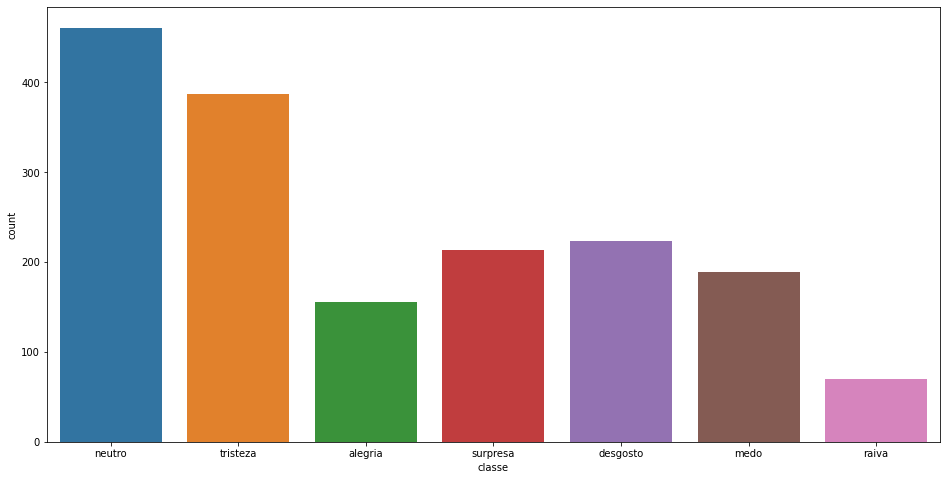

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
sns.countplot(x="classe", ax=ax, data=df_twitter)

### Podemos verificar que as classes estão desbalanceadas.

É necessário balanceá-las?


Mas há outras coisas importantes que devemos saber sobre os dados? Vamos explorar um pouco estes dados olhando diretamente o arquivo csv.

Geralmente Twitters podem conter emojis, emoticons, # e @, então é necessário tratarmos estes casos, inclusive com remoção de caracteres especiais, números, etc.

Outra questão importante é verificarmos a quantidade de caracteres que os textos possuem. Registros com pouco texto podem ser um problema e podem mudar a abordagem a ser utilizada (técnica).


In [ ]:
df_twitter.texto.apply(len).describe()

count    1700.000000
mean      192.362353
std        37.454016
min        90.000000
25%       172.000000
50%       191.000000
75%       207.000000
max       556.000000
Name: texto, dtype: float64

## Pré-processamento dos textos
A primeira coisa que devemos fazer é o pré-processar os textos, removendo trecho inúteis ou pouco significativos. Para limpar as frases, faremos o seguinte:

* **Converter para minúsculo**: Converter todos caracteres para minúsculo;

* **Remover caracteres especiais**: Remover links e nomes de usuários e transformar emojis em textos (não vi isso na exploração que eu fiz, mas como os dados são do Twitter isso pode ocorrer);

* **Remover repetições**: Remover repetições de caracteres (ex: whaaaaaat => what);


* **Remover Stop Words**: Remover stop words comuns.

* **Executar processo de stemização** 


Para o passo das palavras vazias, é importante manter negações (não, nunca, etc) para preservar a intenção.

In [ ]:
# Tokenizador: utilizado para separar uma frase em palavras
tokenizer = RegexpTokenizer(r'\w+')

#para stopword
nltk.download('stopwords')

# para stemização
import nltk  
nltk.download('rslp')

stemmer = nltk.stem.RSLPStemmer()

# Semente aleatória usada neste notebook, para garantir reprodutibilidade de resultados
random_state=5899

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


### Preparando rotina para tratar **Stopwords**
Para isso vamos importar as stop words relacionadas ao idioma portugues da biblioteca **nltk**.

In [ ]:
# Temos que ver se este stopword é portugues de portugal ou portugues do Brasil
lista_stop = set(stopwords.words('portuguese'))
np.transpose(lista_stop)



array({'haja', 'houveram', 'te', 'serão', 'estava', 'com', 'tivermos', 'temos', 'fôramos', 'tem', 'tiver', 'estavam', 'esteve', 'seus', 'tivera', 'tinha', 'estávamos', 'eles', 'você', 'éramos', 'só', 'e', 'elas', 'às', 'tiveram', 'quando', 'isso', 'dos', 'teriam', 'nós', 'minha', 'em', 'uma', 'nossas', 'estou', 'não', 'também', 'vocês', 'suas', 'que', 'dela', 'houverei', 'houveriam', 'fossem', 'essas', 'estivesse', 'tivéramos', 'aquele', 'deles', 'nosso', 'entre', 'meus', 'houvessem', 'teus', 'houverão', 'depois', 'como', 'mas', 'qual', 'houvera', 'seriam', 'estão', 'terei', 'tivéssemos', 'tiverem', 'sejamos', 'das', 'houvermos', 'até', 'isto', 'teríamos', 'de', 'mais', 'estejamos', 'sejam', 'tém', 'tivesse', 'hei', 'hajam', 'aos', 'no', 'para', 'tivessem', 'mesmo', 'estivessem', 'há', 'teve', 'estivera', 'já', 'meu', 'dele', 'estivéramos', 'aqueles', 'houvemos', 'a', 'pelas', 'lhe', 'tuas', 'foram', 'houverá', 'pelo', 'quem', 'seja', 'tenham', 'pelos', 'terá', 'por', 'na', 'estivemos'

In [ ]:
import unicodedata
def strip_accents(text):
    text = normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
    return text

In [ ]:
dias_da_semana = ['segunda-feira', 'terca-feira', 'quarta-feira', 'quinta-feira', 'sexta-feira', 'sabado', 'domingo'\
                 'segunda', 'terca', 'quarta', 'quinta', 'sexta']
nome_meses = ['janeiro', 'fevereiro', 'marco', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro',\
              'novembro', 'dezembro'] 
siglas_estados =  ['ac', 'al', 'ap', 'am', 'ba', 'ce', 'df', 'es', 'go', 'ma', 'mt', 'ms', 'mg', 'pa', 'pb', 'pr',\
                   'pe', 'pi', 'rj', 'rn', 'rs', 'ro', 'rr', 'sc', 'sp', 'se', 'to', \
                   'acre', 'alagoas', 'amapa', 'amazonas', 'bahia', 'ceara', 'espirito santo', 'goias', 'maranhao',\
                   'mato grosso', 'mato grosso do sul', 'minas gerais', 'para', 'paraiba', 'parana', 'pernambuco',\
                   'piaui', 'rio de janeiro', 'rio grande do norte', 'rio grande do sul', 'rondonia', 'roraima',\
                   'santa catarina', 'sao paulo', 'sergipe', 'tocantins', 'brasilia',\
                   'rio branco', 'maceio', 'macapa', 'manaus', 'salvador', 'fortaleza', 'vitoria', 'goiania',\
                   'sao luis', 'cuiaba', 'campo grande', 'belo horizonte', 'belem', 'joao pessoa', 'curitiba',\
                   'recife', 'teresina', 'rio de janeiro', 'natal', 'porto alegre', 'porto velho', 'boa vista',\
                   'florianopolis', 'sao paulo', 'aracaju', 'palmas']
medidas_comprimento = ['km','hm','dam','m', 'mm','cm','dm','metro','metros']
medidas_peso = ['kg','hg','dag','g', 'mg','cg','dg', 'quilo', 'tonelada']
medidas_volume = ['kl','hl','dal','l', 'ml','cl','dl','litro']
posicao = ['primeiro', 'segundo', 'terceiro', 'quarto', 'quinto', 'sexto', 'setimo', 'oitavo', 'nono', 'decimo',\
           'primeira', 'segunda', 'terceira', 'quarta', 'quinta', 'sexta', 'setima', 'oitava', 'nona', 'decima',
           'dezena', 'centena', 'milhar', 'milhares']
outras = ['dia', 'dias', 'mes', 'meses', 'ano', 'anos', 'bimestre', 'trimestre','semestre', 'hora', 'horas', 'periodo',\
          'mil', 'milhao', 'milhoes', 'bilhao', 'bilhoes', 'trilhao', 'trilhoes', \
          'um', 'dois', 'tres', 'quatro', 'cinco', 'seis', 'sete', 'oito', 'nove', 'dez', \
          'comeco', 'inicio', 'fim', 'primeiro', 'primeira', 'ultimo', 'ultima', 'antes', 'depois', 'apos', 'passada',\
          'este', 'estes', 'esta', 'estas', 'deste', 'destes', 'desta', 'destas', 'neste', 'nestes', 'nesta', 'nestas',\
          'durante', 'daquele', 'daqueles', 'daquela', 'daquelas', 'entretanto', 'sobre',\
          'norte', 'sul', 'leste', 'oeste', 'nordeste', 'sudeste', 'sudoeste',  'noroeste'\
          'hoje', 'ontem', 'agora', 'passado', 'futuro', 'madrugada', 'dia', 'noite', 'meio-dia', 'meia-noite']

In [ ]:
def remove_palavras(t,l):
  # remove palavras l do texto t
    return " ".join([p for p in t.split() if (p != "") and (p not in l)])

In [ ]:
def remove_pontuacao(t):
  pontuacao='“!\"\”#%&\'()*+,./:;<=>?@[\\]^_`{|}~ºª„•'
  newstring='' 
  for i in t:
     if(i not in pontuacao):
                  newstring+=i
  t = newstring
  return t

In [ ]:
def trata_texto(texto):
  frase = texto
  
  # coloca tudo em minusculo
  frase = frase.lower()
  # Minúsculas
  
  # remove acentos
  frase = strip_accents(frase)
  
  # Remover e-mail
  frase = re.sub(r'\b[\w\.-]+@[\w\.-]+\b'," ",frase)  

  #frase = frase.replace('[^!.?: ]+', " ")  
  #frase = re.sub("(@[A-Za-z]+)|([^A-Za-z \t])|(\w+:\/\/\S+)"," ",frase)  
    
  frase = remove_pontuacao(frase)
  frase = remove_palavras(frase,dias_da_semana)
  frase = remove_palavras(frase,nome_meses)
  frase = remove_palavras(frase,siglas_estados)
  frase = remove_palavras(frase,medidas_comprimento)
  frase = remove_palavras(frase,medidas_peso)
  frase = remove_palavras(frase,medidas_volume)
  frase = remove_palavras(frase,posicao)
  frase = remove_palavras(frase,outras)
  

  # Remover Moedas
  frase = frase.replace(r'r$', '')
  frase = frase.replace(r'us$', '')
  frase = frase.replace(r'€', '')

  # Remover Rodovias
  frase = re.sub(r'\b\S{2}-\d{3}\b'," ",frase)  
  #frase = frase.replace(r'\b\S{2}-\d{3}\b', '')

  # Remover Horarios
  frase = re.sub(r'\b\d{1,2}h\d{2}\b'," ",frase)  
  frase = re.sub(r'\b\d{1,2}h\b'," ",frase)  

  #Remover Números
  frase = re.sub(r'\d+'," ",frase)  

  #sequência de espaços
  frase = re.sub(r'\s+'," ",frase) 

  # Remove caracteres especiais
  #frase = frase.replace(r"(http|@)\S+", "")
  #frase = re.sub("(\w+:\/\/\S+)","webpage ",frase)
  #frase = emoji.demojize(frase)
  #frase = frase.replace(r"::", ": :")
  #frase = frase.replace(r"’", "'")
  #frase = frase.replace(r"r$", "")
  #frase = frase.replace(r"[^a-z\':_]", " ")

  # Remove repetições
  repeat_pattern = re.compile(r'(.)\1{2,}')
  frase = repeat_pattern.sub(r'\1', frase)

  
  # transformar emoticons em texto
  #frase = token_emoticons(frase).lower()

  # remove caracteres web 
  #frase = BeautifulSoup(unescape(frase), 'lxml').text

  # remove caracteres especiais incluindo números
  #frase = re.sub("(@[A-Za-z]+)|([^A-Za-z \t])|(\w+:\/\/\S+)"," ",frase)
 
   
  # Remove espaços extras, palavras pequenas, stopwords e realiza o stemming
  tokens = tokenizer.tokenize(frase)
  #tokens = [stemmer.stem(palavra) for palavra in tokens if (len(palavra) >= 3 and palavra not in lista_stop)]
  tokens = [stemmer.stem(palavra) for palavra in tokens if (palavra not in lista_stop)]   
  frase = ' '.join(tokens) 
   
  return frase


In [ ]:
#Métricas do tamanho dos textos antes da limpeza e tratamento
tam_texto=[]
for texto in df_twitter['texto']:
    tam_texto.append(len(tokenizer.tokenize(texto)))
print("Média do tamanho dos textos (em palavras): {0:.2f} ".format(statistics.mean(tam_texto)))
print("Mediana do tamanho dos textos (em palavras): {0:.2f} ".format(statistics.median(tam_texto)))
print("Desvio padrão do tamanho dos textos (em palavras): {0:.2f}".format(statistics.stdev(tam_texto)))

Média do tamanho dos textos (em palavras): 31.29 
Mediana do tamanho dos textos (em palavras): 31.00 
Desvio padrão do tamanho dos textos (em palavras): 6.83


### Tratamento do texto e montagem do vocabulário

In [ ]:
#Faz a limpeza do texto
vocabulario=set()
df_twitter['texto'] = df_twitter['texto'].apply(trata_texto)

#Monta vocabulário
for texto in df_twitter['texto']:
    vocabulario.update(set(tokenizer.tokenize(texto)))   

### Como estão os dados depois do tratamento

In [ ]:
#Métricas do tamanho dos textos depois da limpeza e tratamento
tam_texto=[]
for texto in df_twitter['texto']:
    tam_texto.append(len(tokenizer.tokenize(texto)))
print("Média do tamanho dos textos (em palavras): {0:.2f} ".format(statistics.mean(tam_texto)))
print("Mediana do tamanho dos textos (em palavras): {0:.2f} ".format(statistics.median(tam_texto)))
print("Desvio padrão do tamanho dos textos (em palavras): {0:.2f}".format(statistics.stdev(tam_texto)))

Média do tamanho dos textos (em palavras): 18.41 
Mediana do tamanho dos textos (em palavras): 18.00 
Desvio padrão do tamanho dos textos (em palavras): 3.90


In [ ]:
# Salva os registros classificados
df_twitter.to_csv('treino_limpo.csv', index=False, encoding="utf-8", columns=['id','texto','classe'])

## Função para calcular as metricas do desafio


In [ ]:
COLUNAS = [
    'classificador',
    'acuracia',
    'precision',
    'recall',
    'f1-score'
]

df_resultados = pd.DataFrame(columns=COLUNAS)


def guardarresultados(df_resultados, modelo, accuracy, precision, recall, f1):
    df_resultados = df_resultados.append({'classificador': modelo, 'acuracia':accuracy, 'precision': precision, 'recall':recall, 'f1-score':f1}, ignore_index=True)
    return df_resultados

In [ ]:
def get_metrics(y_test, y_predicted):  
    precision = round(precision_score(y_test, y_predicted, pos_label=1, average='macro'),4)             
    recall = round(recall_score(y_test, y_predicted, pos_label=1, average='macro'),4)
    f1 = round(f1_score(y_test, y_predicted, pos_label=1, average='macro'),4)
    accuracy = round(accuracy_score(y_test, y_predicted),4)
    return accuracy, precision, recall, f1

## Preparando massa de dados para os classificadores: 
* Separação em dados em treinamento e teste;
* Criando vetorizador;
* Toquenizando dados usando TF-IDF.

In [ ]:
#Separa dados de treino / teste
df_treino, df_teste = train_test_split(df_twitter, test_size=0.20, stratify=df_twitter['classe'], shuffle=True, random_state=random_state)
print('Tamanho do Treino:',len(df_treino),'- Tamanho do Teste:',len(df_teste))

Tamanho do Treino: 1360 - Tamanho do Teste: 340


In [ ]:
#Instancia o vetorizador TF*IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 1), vocabulary=vocabulario,sublinear_tf=True)

In [ ]:
#Vetoriza TF-IDF os dataframes
# Dataframe original
X=vectorizer.fit_transform(df_twitter['texto'])
y=df_twitter['classe']

#Dataframes de treino e teste
X_treino = vectorizer.fit_transform(df_treino['texto'])
y_treino=df_treino['classe']

X_teste= vectorizer.fit_transform(df_teste['texto'])
y_teste =  df_teste['classe']

#Imprime tipo e formato da matriz esparsa
print("Matriz TF-IDF: ", type(X), X.shape)

Matriz TF-IDF:  <class 'scipy.sparse.csr.csr_matrix'> (1700, 5711)


#Criação das instâncias dos classificadores

In [ ]:
#Classificadores testados / utilizados
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
# Logistc Regression
clf_LR = LogisticRegression(solver='lbfgs', multi_class='auto', class_weight='balanced', penalty='l2', C=2, random_state=random_state, tol=1e-5)

# Ramdom Florest
clf_RF = RandomForestClassifier(n_estimators=200, random_state=random_state)

# Decision Tree
clf_DT = DecisionTreeClassifier()

# Naive Bayes
clf_MNB = MultinomialNB(alpha=0.1)

# Stochastic Gradient Descent
clf_SGD = SGDClassifier(loss='modified_huber', penalty='l2', alpha=2e-3, random_state=random_state, max_iter=5, tol=None)

# Multi-layer Perceptron
clf_MLP= MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(70, ), random_state=random_state)

In [ ]:
#Roda o Logistic Regressor com validação cruzada 10 fold
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=random_state)
results_LR = cross_validate(clf_LR, X_treino, y_treino, cv = cv, return_train_score=False, scoring='f1_macro')
print("F1-macro: {0:.5f} +- {1:.5f}".format( results_LR['test_score'].mean()* 100,results_LR['test_score'].std()* 100 ))

F1-macro: 50.21799 +- 6.02574


In [ ]:
#Roda o Ramdom Florest com validação cruzada 10 fold
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=random_state)
results_RF = cross_validate(clf_RF, X_treino, y_treino, cv = cv, return_train_score=False, scoring='f1_macro')
print("F1-macro: {0:.5f} +- {1:.5f}".format( results_RF['test_score'].mean()* 100,results_RF['test_score'].std()* 100 ))

F1-macro: 33.28623 +- 4.37088


In [ ]:
#Roda o Decision Tree com validação cruzada 10 fold
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=random_state)
results_DT = cross_validate(clf_DT, X_treino, y_treino, cv = cv, return_train_score=False, scoring='f1_macro')
print("F1-macro: {0:.5f} +- {1:.5f}".format( results_DT['test_score'].mean()* 100,results_DT['test_score'].std()* 100 ))

F1-macro: 33.28335 +- 4.84580


In [ ]:
#Roda o Naive Bayes com validação cruzada 10 fold
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=random_state)
results_MNB = cross_validate(clf_MNB, X_treino, y_treino, cv = cv, return_train_score=False, scoring='f1_macro')
print("F1-macro: {0:.5f} +- {1:.5f}".format( results_MNB['test_score'].mean()* 100,results_MNB['test_score'].std()* 100 ))

F1-macro: 41.93086 +- 2.64399


In [ ]:
#Roda o SGD Classifier com validação cruzada 10 fold
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=random_state)
results_SGD = cross_validate(clf_SGD, X_treino, y_treino, cv = cv, return_train_score=False, scoring='f1_macro')
print("F1-macro: {0:.5f} +- {1:.5f}".format( results_SGD['test_score'].mean()* 100,results_SGD['test_score'].std()* 100 ))

F1-macro: 43.76567 +- 4.81811


In [ ]:
#Roda o MLP Classifier com validação cruzada 10 fold
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=random_state)
results_MLP = cross_validate(clf_MLP, X_treino, y_treino, cv = cv, return_train_score=False,scoring='f1_macro')
print("F1-macro: {0:.5f} +- {1:.5f}".format( results_MLP['test_score'].mean()* 100,results_MLP['test_score'].std()* 100 ))

F1-macro: 45.24534 +- 3.49601


### Buscando os melhores hiperparâmetros para o classificador (regressão logística)

In [ ]:
tuned_parameters = {
    "solver" : ['lbfgs', 'liblinear'],
    "tol" : uniform(1e-6, 1e-4),
    "C" : uniform(0, 5),
    "intercept_scaling" : uniform(0, 2)
}
modelo = RandomizedSearchCV(estimator=LogisticRegression(multi_class='auto', class_weight='balanced', penalty='l2', random_state=random_state),
                    param_distributions=tuned_parameters,
                    n_iter = 64,
                    cv = cv,
                    scoring='f1_macro',      
                    random_state = random_state)
modelo.fit(X_treino, y_treino)
clf_Melhor= modelo.best_estimator_
print("Melhor modelo para o classificador Logistic Regression: ",clf_Melhor)
print("Melhor F1 score: ", modelo.best_score_*100)

Melhor modelo para o classificador Logistic Regression:  LogisticRegression(C=0.652940877702351, class_weight='balanced',
                   intercept_scaling=1.6798003458681157, random_state=5899,
                   tol=9.277852512687244e-05)
Melhor F1 score:  51.25740685834319


In [ ]:
#Roda o Logistic Regressor otimizado com o RandomSearch e validação cruzada 10 fold
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=random_state)
MelhorResultado = cross_validate(clf_Melhor, X_treino, y_treino, cv = cv, return_train_score=False, scoring='f1_macro')
print("F1-macro: {0:.5f} +- {1:.5f}".format( MelhorResultado['test_score'].mean()* 100,MelhorResultado['test_score'].std()* 100 ))

F1-macro: 51.25741 +- 3.77270


## Roda e avalia os classificadores com a massa de dados de teste

In [ ]:
# Avalia a performance do classificador Random Florest, usando a massa reservada para testes
f1=list()
acuracia=list()
clf_RF.fit(X_treino, y_treino)
y_predicted = clf_RF.predict(X_teste)
print(metrics.classification_report(y_teste.values,y_predicted,digits=4))
f1.append(f1_score(y_teste, y_predicted, average='macro'))
acuracia.append(accuracy_score(y_teste, y_predicted))

              precision    recall  f1-score   support

     alegria     0.0000    0.0000    0.0000        31
    desgosto     0.6000    0.2000    0.3000        45
        medo     0.5000    0.2105    0.2963        38
      neutro     0.5030    0.9022    0.6459        92
       raiva     0.0000    0.0000    0.0000        14
    surpresa     0.5938    0.4419    0.5067        43
    tristeza     0.5000    0.7143    0.5882        77

    accuracy                         0.5118       340
   macro avg     0.3853    0.3527    0.3339       340
weighted avg     0.4597    0.5118    0.4449       340



In [ ]:
# Avalia a performance do classificador Decison Tree, usando a massa reservada para testes
clf_DT.fit(X_treino, y_treino)
y_predicted = clf_DT.predict(X_teste)
print(metrics.classification_report(y_teste.values,y_predicted,digits=4))
f1.append(f1_score(y_teste, y_predicted, average='macro'))
acuracia.append(accuracy_score(y_teste, y_predicted))

              precision    recall  f1-score   support

     alegria     0.3000    0.1935    0.2353        31
    desgosto     0.2500    0.2222    0.2353        45
        medo     0.4815    0.3421    0.4000        38
      neutro     0.5424    0.6957    0.6095        92
       raiva     0.3571    0.3571    0.3571        14
    surpresa     0.4706    0.3721    0.4156        43
    tristeza     0.5172    0.5844    0.5488        77

    accuracy                         0.4676       340
   macro avg     0.4170    0.3953    0.4002       340
weighted avg     0.4524    0.4676    0.4538       340



In [ ]:
# Avalia a performance do classificador Naive Bayes, usando a massa reservada para testes
clf_MNB.fit(X_treino, y_treino)
y_predicted = clf_MNB.predict(X_teste)
print(metrics.classification_report(y_teste.values,y_predicted,digits=4))
f1.append(f1_score(y_teste, y_predicted, average='macro'))
acuracia.append(accuracy_score(y_teste, y_predicted))

              precision    recall  f1-score   support

     alegria     0.3000    0.0968    0.1463        31
    desgosto     0.5294    0.4000    0.4557        45
        medo     0.5000    0.2895    0.3667        38
      neutro     0.5854    0.7826    0.6698        92
       raiva     0.5000    0.0714    0.1250        14
    surpresa     0.5098    0.6047    0.5532        43
    tristeza     0.5408    0.6883    0.6057        77

    accuracy                         0.5412       340
   macro avg     0.4951    0.4190    0.4175       340
weighted avg     0.5192    0.5412    0.5082       340



In [ ]:
# Avalia a performance do classificador SGD, usando a massa reservada para testes
clf_SGD.fit(X_treino, y_treino)
y_predicted = clf_SGD.predict(X_teste)
print(metrics.classification_report(y_teste.values,y_predicted,digits=4))
f1.append(f1_score(y_teste, y_predicted, average='macro'))
acuracia.append(accuracy_score(y_teste, y_predicted))

              precision    recall  f1-score   support

     alegria     0.5000    0.0968    0.1622        31
    desgosto     0.4848    0.3556    0.4103        45
        medo     0.4643    0.3421    0.3939        38
      neutro     0.5342    0.8478    0.6555        92
       raiva     0.5000    0.0714    0.1250        14
    surpresa     0.5610    0.5349    0.5476        43
    tristeza     0.6310    0.6883    0.6584        77

    accuracy                         0.5500       340
   macro avg     0.5250    0.4196    0.4218       340
weighted avg     0.5406    0.5500    0.5140       340



In [ ]:
# Avalia a performance do classificador MLP, usando a massa reservada para testes
clf_MLP.fit(X_treino, y_treino)
y_predicted = clf_MLP.predict(X_teste)
print(metrics.classification_report(y_teste.values,y_predicted,digits=4))
f1.append(f1_score(y_teste, y_predicted, average='macro'))
acuracia.append(accuracy_score(y_teste, y_predicted))

              precision    recall  f1-score   support

     alegria     0.4000    0.1290    0.1951        31
    desgosto     0.5833    0.4667    0.5185        45
        medo     0.4545    0.3947    0.4225        38
      neutro     0.5820    0.7717    0.6636        92
       raiva     0.4000    0.2857    0.3333        14
    surpresa     0.4898    0.5581    0.5217        43
    tristeza     0.6375    0.6623    0.6497        77

    accuracy                         0.5588       340
   macro avg     0.5067    0.4669    0.4721       340
weighted avg     0.5447    0.5588    0.5400       340



In [ ]:
# Avalia a performance do classificador LR, usando a massa reservada para testes
clf_LR.fit(X_treino, y_treino)
y_predicted = clf_LR.predict(X_teste)
print(metrics.classification_report(y_teste.values,y_predicted,digits=4))
f1.append(f1_score(y_teste, y_predicted, average='macro'))
acuracia.append(accuracy_score(y_teste, y_predicted))

              precision    recall  f1-score   support

     alegria     0.3333    0.2581    0.2909        31
    desgosto     0.5250    0.4667    0.4941        45
        medo     0.4545    0.3947    0.4225        38
      neutro     0.6161    0.7500    0.6765        92
       raiva     0.4286    0.4286    0.4286        14
    surpresa     0.5185    0.6512    0.5773        43
    tristeza     0.6984    0.5714    0.6286        77

    accuracy                         0.5618       340
   macro avg     0.5106    0.5029    0.5026       340
weighted avg     0.5588    0.5618    0.5552       340



In [ ]:
# Avalia a performance do classificador LR otimizado com RandomSearch, usando a massa reservada para testes
clf_Melhor.fit(X_treino, y_treino)
y_predicted = clf_Melhor.predict(X_teste)
print(metrics.classification_report(y_teste.values,y_predicted, digits=4))
f1.append(f1_score(y_teste, y_predicted, average='macro'))
acuracia.append(accuracy_score(y_teste, y_predicted))

              precision    recall  f1-score   support

     alegria     0.3000    0.2903    0.2951        31
    desgosto     0.5263    0.4444    0.4819        45
        medo     0.4571    0.4211    0.4384        38
      neutro     0.6182    0.7391    0.6733        92
       raiva     0.3077    0.5714    0.4000        14
    surpresa     0.5306    0.6047    0.5652        43
    tristeza     0.7500    0.5065    0.6047        77

    accuracy                         0.5471       340
   macro avg     0.4986    0.5111    0.4941       340
weighted avg     0.5650    0.5471    0.5467       340



In [ ]:
#Imprime o valor no gráfico de barras
def autolabel(rects):

    for rect in rects:
        height = rect.get_height()
        plt.annotate('{0:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

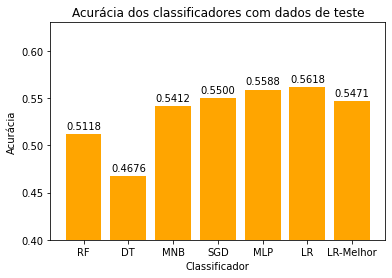

In [ ]:
#Imprime o gráfico de barras da acuracia
classificadores = ['RF', 'DT', 'MNB','SGD', 'MLP', 'LR', 'LR-Melhor']
barra= plt.bar(classificadores, acuracia, color="orange")
autolabel(barra)
plt.xticks(classificadores)
plt.ylabel('Acurácia')
plt.xlabel('Classificador')
plt.ylim(.4,.63)
plt.title('Acurácia dos classificadores com dados de teste')
plt.show()

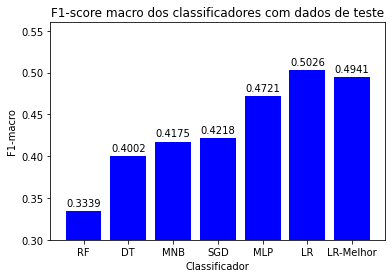

In [ ]:
#Imprime o gráfico de barras do F1-macro
barra=plt.bar(classificadores, f1, color="blue")
autolabel(barra)
plt.xticks(classificadores)
plt.ylabel('F1-macro')
plt.xlabel('Classificador')
plt.ylim(.3,.56)
plt.title('F1-score macro dos classificadores com dados de teste')
plt.show()

## Verificando F1 - Score para dados de teste

In [ ]:
#Abre dataset de predição
df_class_final=pd.read_csv('desafio-pln_teste-com-classe.csv')

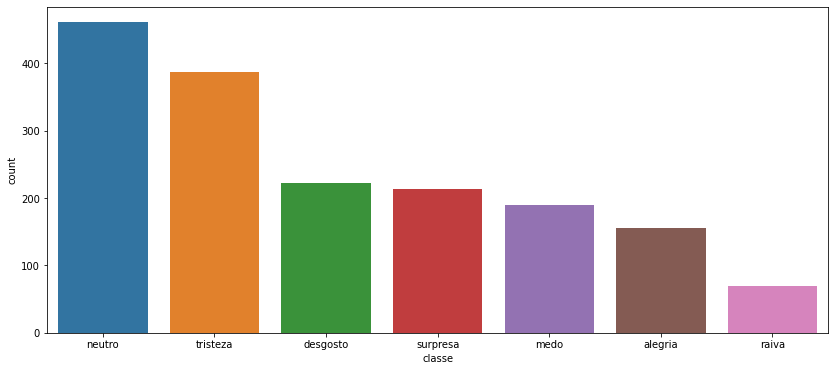

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
sns.countplot(x="classe", ax=ax, data=df_twitter, order = df_twitter['classe'].value_counts().index)

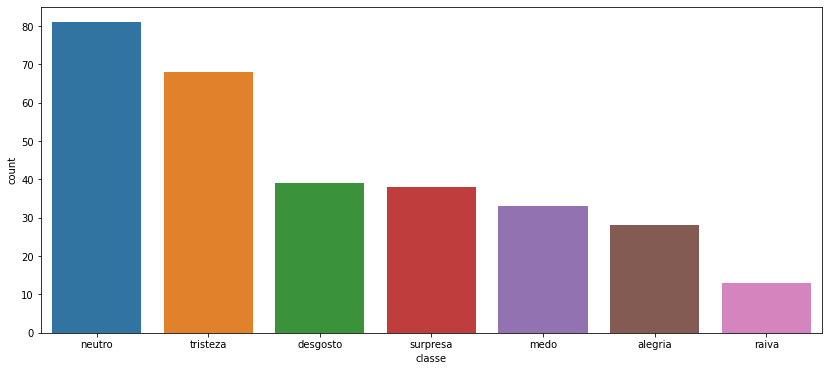

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
sns.countplot(x="classe", ax=ax, data=df_class_final, order = df_class_final['classe'].value_counts().index)

In [ ]:
print("Percentual de participação nos dados originais")
print((df_twitter.classe.value_counts()/df_twitter.shape[0])*100)

Percentual de participação nos dados originais
neutro      27.117647
tristeza    22.764706
desgosto    13.117647
surpresa    12.588235
medo        11.117647
alegria      9.176471
raiva        4.117647
Name: classe, dtype: float64


In [ ]:
print("Percentual de participação nos dados do desafio")
print((df_class_final.classe.value_counts()/df_class_final.shape[0])*100)

Percentual de participação nos dados do desafio
neutro      27.000000
tristeza    22.666667
desgosto    13.000000
surpresa    12.666667
medo        11.000000
alegria      9.333333
raiva        4.333333
Name: classe, dtype: float64


In [ ]:
#Limpa o texto
df_class_final['texto'] = df_class_final['texto'].apply(trata_texto)

#Monta vocabulário completo
for texto in df_class_final['texto']:
    vocabulario.update(set(tokenizer.tokenize(texto)))  
#Tamanho e exemplo do vocabulário
print(len(vocabulario))

6111


In [ ]:
#Métricas do tamanho dos textos depois da limpeza e tratamento
tam_texto=[]
for texto in df_class_final['texto']:
    tam_texto.append(len(tokenizer.tokenize(texto)))
print("Média do tamanho dos textos (em palavras): {0:.2f} ".format(statistics.mean(tam_texto)))
print("Mediana do tamanho dos textos (em palavras): {0:.2f} ".format(statistics.median(tam_texto)))
print("Desvio padrão do tamanho dos textos (em palavras): {0:.2f}".format(statistics.stdev(tam_texto)))

Média do tamanho dos textos (em palavras): 18.23 
Mediana do tamanho dos textos (em palavras): 18.00 
Desvio padrão do tamanho dos textos (em palavras): 3.63


In [ ]:
#Instancia o vetorizador TF*IDF, agora com o novo vocabulário
vectorizer = TfidfVectorizer(ngram_range=(1, 1), vocabulary=vocabulario,sublinear_tf=True)
#Vetoriza TF-IDF os dataframes completos e a classificar
X=vectorizer.fit_transform(df_twitter['texto'])
y=df_twitter['classe']
X_final = vectorizer.fit_transform(df_class_final['texto'])
y_final = df_class_final['classe']

### Agora vamos ver os resultados dos classificadores usando o arquivo de desafio

In [ ]:
#Retreina com a base completa usando RF
clf_RF.fit(X, y)

RandomForestClassifier(n_estimators=200, random_state=5899)

In [ ]:
#Realiza a previsão do dataset final
y_predicted = clf_RF.predict(X_final)
print(metrics.classification_report(y_final,y_predicted,digits=4))


              precision    recall  f1-score   support

     alegria     0.6000    0.1071    0.1818        28
    desgosto     0.4783    0.2821    0.3548        39
        medo     0.6154    0.2424    0.3478        33
      neutro     0.5504    0.8765    0.6762        81
       raiva     0.0000    0.0000    0.0000        13
    surpresa     0.5862    0.4474    0.5075        38
    tristeza     0.5400    0.7941    0.6429        68

    accuracy                         0.5467       300
   macro avg     0.4815    0.3928    0.3873       300
weighted avg     0.5311    0.5467    0.4939       300



In [ ]:
acuracia, precisao, recuperacao, f1Score = get_metrics(y_final, y_predicted)
df_resultados = guardarresultados(df_resultados, 'RF', acuracia, precisao, recuperacao, f1Score)

In [ ]:
#Retreina com a base completa usando DT
clf_DT.fit(X, y)

DecisionTreeClassifier()

In [ ]:
#Realiza a previsão do dataset final
y_predicted = clf_DT.predict(X_final)
print(metrics.classification_report(y_final,y_predicted,digits=4))


              precision    recall  f1-score   support

     alegria     0.2632    0.1786    0.2128        28
    desgosto     0.2400    0.3077    0.2697        39
        medo     0.3750    0.1818    0.2449        33
      neutro     0.5667    0.6296    0.5965        81
       raiva     0.2857    0.1538    0.2000        13
    surpresa     0.3111    0.3684    0.3373        38
    tristeza     0.4932    0.5294    0.5106        68

    accuracy                         0.4200       300
   macro avg     0.3621    0.3356    0.3388       300
weighted avg     0.4136    0.4200    0.4100       300



In [ ]:
acuracia, precisao, recuperacao, f1Score = get_metrics(y_final, y_predicted)
df_resultados = guardarresultados(df_resultados, 'DT', acuracia, precisao, recuperacao, f1Score)

In [ ]:
#Retreina com a base completa usando MNB
clf_MNB.fit(X, y)

MultinomialNB(alpha=0.1)

In [ ]:
#Realiza a previsão do dataset final
y_predicted = clf_MNB.predict(X_final)
print(metrics.classification_report(y_final,y_predicted,digits=4))


              precision    recall  f1-score   support

     alegria     0.3333    0.1071    0.1622        28
    desgosto     0.5161    0.4103    0.4571        39
        medo     0.5625    0.2727    0.3673        33
      neutro     0.6400    0.7901    0.7072        81
       raiva     0.0000    0.0000    0.0000        13
    surpresa     0.4706    0.4211    0.4444        38
    tristeza     0.4818    0.7794    0.5955        68

    accuracy                         0.5367       300
   macro avg     0.4292    0.3972    0.3905       300
weighted avg     0.5017    0.5367    0.4972       300



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
acuracia, precisao, recuperacao, f1Score = get_metrics(y_final, y_predicted)
df_resultados = guardarresultados(df_resultados, 'MNB', acuracia, precisao, recuperacao, f1Score)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Retreina com a base completa usando SGD
clf_SGD.fit(X, y)

SGDClassifier(alpha=0.002, loss='modified_huber', max_iter=5, random_state=5899,
              tol=None)

In [ ]:
#Realiza a previsão do dataset final
y_predicted = clf_SGD.predict(X_final)
print(metrics.classification_report(y_final,y_predicted,digits=4))


              precision    recall  f1-score   support

     alegria     0.2500    0.0714    0.1111        28
    desgosto     0.5185    0.3590    0.4242        39
        medo     0.6000    0.3636    0.4528        33
      neutro     0.5820    0.8765    0.6995        81
       raiva     0.3333    0.0769    0.1250        13
    surpresa     0.5946    0.5789    0.5867        38
    tristeza     0.6145    0.7500    0.6755        68

    accuracy                         0.5767       300
   macro avg     0.4990    0.4395    0.4393       300
weighted avg     0.5429    0.5767    0.5370       300



In [ ]:
acuracia, precisao, recuperacao, f1Score = get_metrics(y_final, y_predicted)
df_resultados = guardarresultados(df_resultados, 'SGD', acuracia, precisao, recuperacao, f1Score)

In [ ]:
#Retreina com a base completa usando SGD
clf_MLP.fit(X, y)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(70,), random_state=5899,
              solver='lbfgs')

In [ ]:
#Realiza a previsão do dataset final
y_predicted = clf_MLP.predict(X_final)
print(metrics.classification_report(y_final,y_predicted,digits=4))


              precision    recall  f1-score   support

     alegria     0.2857    0.1429    0.1905        28
    desgosto     0.4865    0.4615    0.4737        39
        medo     0.4242    0.4242    0.4242        33
      neutro     0.6327    0.7654    0.6927        81
       raiva     0.2727    0.2308    0.2500        13
    surpresa     0.6129    0.5000    0.5507        38
    tristeza     0.6316    0.7059    0.6667        68

    accuracy                         0.5600       300
   macro avg     0.4780    0.4615    0.4641       300
weighted avg     0.5400    0.5600    0.5448       300



In [ ]:
acuracia, precisao, recuperacao, f1Score = get_metrics(y_final, y_predicted)
df_resultados = guardarresultados(df_resultados, 'MLP', acuracia, precisao, recuperacao, f1Score)

In [ ]:
#Retreina com a base completa usando LR
clf_LR.fit(X, y)

LogisticRegression(C=2, class_weight='balanced', random_state=5899, tol=1e-05)

In [ ]:
#Realiza a previsão do dataset final
y_predicted = clf_LR.predict(X_final)
print(metrics.classification_report(y_final,y_predicted,digits=4))


              precision    recall  f1-score   support

     alegria     0.2800    0.2500    0.2642        28
    desgosto     0.4359    0.4359    0.4359        39
        medo     0.5517    0.4848    0.5161        33
      neutro     0.6742    0.7407    0.7059        81
       raiva     0.4118    0.5385    0.4667        13
    surpresa     0.5500    0.5789    0.5641        38
    tristeza     0.7213    0.6471    0.6822        68

    accuracy                         0.5767       300
   macro avg     0.5178    0.5251    0.5193       300
weighted avg     0.5765    0.5767    0.5750       300



In [ ]:
acuracia, precisao, recuperacao, f1Score = get_metrics(y_final, y_predicted)
df_resultados = guardarresultados(df_resultados, 'LR', acuracia, precisao, recuperacao, f1Score)

In [ ]:
#Retreina com a base completa usando LR Otimizado
clf_Melhor.fit(X, y)

LogisticRegression(C=0.652940877702351, class_weight='balanced',
                   intercept_scaling=1.6798003458681157, random_state=5899,
                   tol=9.277852512687244e-05)

In [ ]:
#Realiza a previsão do dataset final
y_predicted = clf_Melhor.predict(X_final)
print(metrics.classification_report(y_final,y_predicted,digits=4))


              precision    recall  f1-score   support

     alegria     0.3462    0.3214    0.3333        28
    desgosto     0.4857    0.4359    0.4595        39
        medo     0.5862    0.5152    0.5484        33
      neutro     0.6739    0.7654    0.7168        81
       raiva     0.4737    0.6923    0.5625        13
    surpresa     0.6216    0.6053    0.6133        38
    tristeza     0.7419    0.6765    0.7077        68

    accuracy                         0.6100       300
   macro avg     0.5613    0.5731    0.5631       300
weighted avg     0.6093    0.6100    0.6072       300



In [ ]:
acuracia, precisao, recuperacao, f1Score = get_metrics(y_final, y_predicted)
df_resultados = guardarresultados(df_resultados, 'LR Otimizado', acuracia, precisao, recuperacao, f1Score)


In [ ]:
df_resultados.head(10)


,classificador,acuracia,precision,recall,f1-score
0,RF,0.5467,0.4815,0.3928,0.3873
1,DT,0.4200,0.3621,0.3356,0.3388
2,MNB,0.5367,0.4292,0.3972,0.3905
3,SGD,0.5767,0.4990,0.4395,0.4393
4,MLP,0.5600,0.4780,0.4615,0.4641
5,LR,0.5767,0.5178,0.5251,0.5193
6,LR Otimizado,0.6100,0.5613,0.5731,0.5631
